In [26]:
# import
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
%matplotlib inline
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [27]:
# 데이터 가져오기
df = pd.read_csv('../data/BankChurners.csv')
# column drop
df = df.drop(columns=['CLIENTNUM', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'])

# rename columns
new_names = {'Attrition_Flag' : 'Exited',
                    'Customer_Age' : 'Age',
                    'Dependent_count' : 'Dependents',
                    'Education_Level' : 'Education',
                    'Marital_Status' : 'Marital',
                    'Income_Category': 'Income',
                    'Card_Category' : 'Card_Type',
                    'Months_on_book' : 'Tenure',
                    'Total_Relationship_Count' : 'Product_Cnt',
                    'Months_Inactive_12_mon' : 'Inactive_Months',
                    'Contacts_Count_12_mon' : 'Contacts_Cnt',
                    'Total_Revolving_Bal' : 'Revolv_Bal',
                    'Avg_Open_To_Buy' : 'Avg_OTB',
                    'Avg_Utilization_Ratio' : 'Avg_Util_Ratio',
                    'Total_Trans_Amt' : 'Trans_Amt',
                    'Total_Trans_Ct' : 'Trans_Cnt',
                    'Total_Amt_Chng_Q4_Q1' : 'Amt_Chng_Q4_Q1',
                    'Total_Ct_Chng_Q4_Q1' : 'Cnt_Chng_Q4_Q1'
}

df = df.rename(columns=new_names)

# 데이터 프레임 컬럼 순서 변경
df = df[['Exited', 'Age', 'Gender', 'Dependents', 'Education', 'Marital', 'Income', 'Card_Type', 'Tenure', 'Product_Cnt', 'Inactive_Months', 'Contacts_Cnt', 'Credit_Limit', 'Revolv_Bal', 'Avg_OTB', 'Avg_Util_Ratio', 'Trans_Amt', 'Trans_Cnt', 'Amt_Chng_Q4_Q1', 'Cnt_Chng_Q4_Q1']]

In [28]:
# 변수별 encoding
mapping = {
    'Exited': {'Existing Customer': 0, 'Attrited Customer': 1},
    'Gender': {'M': 0, 'F': 1},
    'Education': {'Uneducated': 0, 'High School': 1, 'College': 2, 'Graduate' : 3, 'Post-Graduate': 4, 'Doctorate': 5, 'Unknown': 6},
    'Marital': {'Single': 0, 'Married': 1, 'Divorced': 2, 'Unknown': 3},
    'Income': {'Less than $40K': 0, '$40K - $60K': 1, '$60K - $80K': 2, '$80K - $120K': 3, '$120K +': 4, 'Unknown': 5},
    'Card_Type': {'Blue': 0, 'Silver': 1, 'Gold': 2, 'Platinum': 3}
}

df = df.replace(mapping)

In [29]:
from sklearn.preprocessing import StandardScaler

features = df[['Product_Cnt', 'Inactive_Months', 'Contacts_Cnt', 'Revolv_Bal', 'Avg_Util_Ratio', 'Trans_Amt', 'Trans_Cnt', 'Amt_Chng_Q4_Q1', 'Cnt_Chng_Q4_Q1']].values
label = df['Exited'].values

std = StandardScaler()
features_scaled = std.fit_transform(features)

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_scaled, label,
                                                    test_size=0.2,
                                                    stratify=label,
                                                    random_state=13)


In [31]:
import numpy as np

np.unique(y_test, return_counts=True)

(array([0, 1], dtype=int64), array([1701,  325], dtype=int64))

## OverSampling (SMOTE)


> ### smote

In [32]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [33]:
np.unique(y_train_resampled, return_counts=True)

(array([0, 1], dtype=int64), array([6799, 6799], dtype=int64))

<BarContainer object of 2 artists>

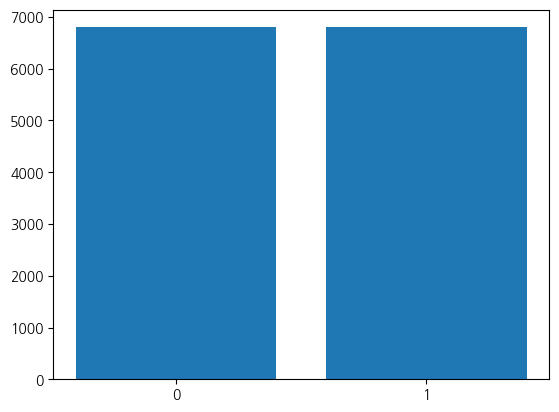

In [41]:
# 오버샘플링 확인
count_0 = np.sum(y_train_resampled==0)
count_1 = np.sum(y_train_resampled==1)

plt.bar(['0', '1'], [count_0, count_1])

In [42]:
from xgboost import XGBClassifier

# 최적의 하이퍼파라미터로 XGBoost 모델 생성
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    seed=0,
    gamma=0,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    n_estimators=300,
    subsample=0.7
)

model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 테스트 데이터로 예측 수행
y_pred = model.predict(X_test)
y_pred_probs = model.predict_proba(X_test)[:, 1]

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# 정밀도 평가
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# 재현율 평가
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# F1-score 평가
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

# AUC-ROC 평가
roc_auc = roc_auc_score(y_test, y_pred_probs)
print("AUC-ROC:", roc_auc)


Accuracy: 0.9619940769990128
Precision: 0.8463687150837989
Recall: 0.9323076923076923
F1-score: 0.8872620790629575
AUC-ROC: 0.9899190521412742


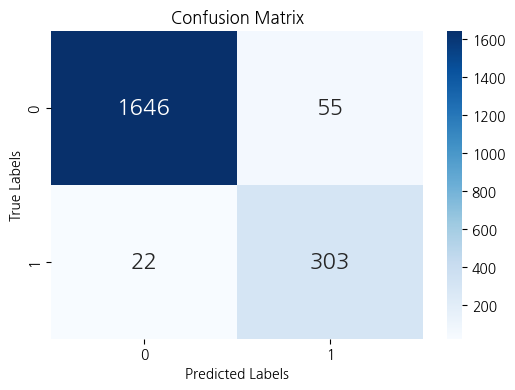

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 테스트 데이터로 예측 수행
y_pred = model.predict(X_test)

# Confusion Matrix 계산
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [38]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1701
           1       0.85      0.93      0.89       325

    accuracy                           0.96      2026
   macro avg       0.92      0.95      0.93      2026
weighted avg       0.96      0.96      0.96      2026



In [39]:
cm = confusion_matrix(y_test, y_pred)

TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

specificity = TN / (TN + FP)
npv = TN / (TN + FN)

print('specificity : ', specificity)
print('npv : ', npv)

specificity :  0.9676660787771899
npv :  0.986810551558753


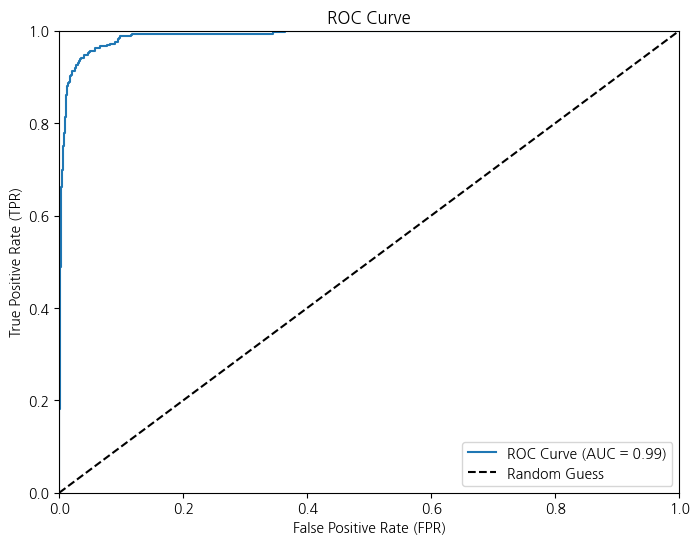

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 테스트 데이터로 예측 수행
y_pred_probs = model.predict_proba(X_test)[:, 1]

# ROC curve 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# ROC curve 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_pred_probs)))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
